# COMP90051 Project 2
**Name:** *enter your name here*

**Student ID:** *your id here*

In [3]:
# You can add additional imports here
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
# Additional imports
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
import time
from copy import copy
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore")




## 0. Loading the dataset

In [4]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

In [5]:
#Helper Function
# 1 - Print Accuracy Score Of Model  
def printAccuracyScore(modelName,score):
    print(modelName, "Accuracy: {}".format(score))

# 1 - Avoid Duplicate Legend     
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
    

## 1. Applying logistic regression

In [6]:
def train_logistic_regression(X, y, **args):
    """
    Train a logistic regression model on dataset (X, y) and return trained model.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
    # your code here
    # run logistic regression model
    # NOTE = Find Best parameters  #Best: 0.302222 using {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
    start = time.time()
    
    log_reg = LogisticRegression(multi_class='multinomial',C=0.01,penalty='l2',solver='lbfgs')
    model = log_reg.fit(X, y)

    stop = time.time()
    print(f"Training time: {stop - start}s")

    return model


In [7]:
def evaluate_logistic_regression_accuracy(Xt, yt, model):
    """
    Apply logistic regression prediction on dataset Xt and evaluate accuracy against yt,
    returing the accuracy results as a scalar.
    Xt: matrix of real values, size m x d
    yt: vector of string labels, size m
    """
    # your code here
    y_pred = model.predict(Xt)
    score = accuracy_score(yt, y_pred)
    #print("Accuracy: {}".format(accuracy_score(yt, y_pred)))
    return score

  

In [8]:
# your code here for training, evaluating & plotting results

# Traning and Evaluation of Model (model_subset) with Subest of y_pool.

model_subset = train_logistic_regression(X_pool[seed_set],y_pool[seed_set])
score_model_subset = evaluate_logistic_regression_accuracy(X_test,y_test,model_subset)
#print("model_subset Accuracy: {}".format(score_model_subset))
printAccuracyScore("model_subset",score_model_subset)
print("\n")

# Traning and Evaluation of  Model (model_max_pool) with Max Pool 
model_max_pool = train_logistic_regression(X_pool,y_pool)
score_model_max_pool = evaluate_logistic_regression_accuracy(X_test,y_test,model_max_pool)
printAccuracyScore("model_max_pool",score_model_max_pool)

# Graphs
# Evaluation Report 




Training time: 0.7499816417694092s
model_subset Accuracy: 0.31732365145228214


Training time: 9.661001443862915s
model_max_pool Accuracy: 0.5675311203319502


## 2. Active learning framework with Random selection

In [9]:
def random_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a model (not used)
    returns a vector of scores of length n. Each entry reflects the priority 
    of the corresponding instance. Higher means better.
    """
    # Creating a score array using random numbers of length of X 
    scores = np.random.randint(1,len(X),len(X))
    return scores
    

In [10]:
def pool_based_active_learning(X_pool, y_pool, seed_ids,
                               train_func, select_func,
                               max_size, batch_size, **args):
    """
    Perform an active learning simulation, which starts by training on a seed set,
    then iteratively applies the selection function to rank instances in the pool,
    selects the top few instances which are included into the training set and the
    process repeats. 
        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        seed_ids: initial labelled set set, as a list of indices [0..n-1] into pool
        train_func: function which given (X, y, optional args) returns a trained model
        select_func: function which given (X, optional args) returns a sequence of scores
        max_size: stopping condition for active learning, when labelled data reaches given size
        batch_size: number of instances to be labelled in each iteration
        args: optional arguments passed to training and selection function
    returns the sequence of trained models 
    """
    trained_models =[]
    seed = copy(seed_ids)   # To avoid Pass by Refernce Update 
    i = 0 
    # 1: U = pool of unlabelled instances, {x} 
    U =  np.delete(X_pool,seed, axis=0)
    # 2: L = set of initial labelled instances, {hx,yi} 
    L = [X_pool[seed],y_pool[seed]]   # L = (x,y)  
    # 3: b = number of instances to label in each step 
    b =  batch

    # 4: for t = 1,2,...,T do 
    #for i in range(1,46):  # Loop will run from 300 to 3000 Instances
    #TODO: Test Max Size is integer or not  
    while(len(seed) < max_size):
        i+=1
    # 5:  θ(t) = train(L) 
        Theta_model=train_func(L[0],L[1]) # train_ensemble returns (ensemble_model-just return 2 models,trained_logidtic_model) = theta_model
   
    # 6:  score all instances in pool, r = select(U) 
        r = select_func(U,Theta_model)  #Note Argmax Check <- ensembled_model to assign ranks to all the seedset data
        # here select_func is querybycommitee
    # 7:  for all j ∈ argmax(b,r) do 
        max_indices = np.argpartition(r,-b)[-b:]
        for j in max_indices:
    # 8:      reveal label y     
    # 9:      add hxj,yji to L
            L[0] = np.append(L[0],[X_pool[j]], axis=0)
            L[1]= np.append(L[1],y_pool[j])
            seed.append(j)
    # 10:     remove xj from U 
            U = np.delete(X_pool,seed,axis=0)   # (U,j)
             #  Calculate and report our model's accuracy.                       
    # 11:    end for 
    # 12: end for 
    # 13: return {θ(t)}T t=1
 #  Calculate and report our model's accuracy. REMOVE IT
        # model_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model[2])
        # print('Accuracy after query {n}: {acc:0.4f}'.format(n=i, acc=model_accuracy))
    # Save our model's performance for plotting.
        trained_models.append(Theta_model)

    
    return trained_models  #model list return 



In [11]:
# Theta_model=[]
# d=[9149,7806,431,5765,3554,3550] 
# r=random_select(d,Theta_model)  #Note Argmax Check
# print(r)
# b = 2 
#     # 7:  for all j ∈ argmax(b,r) do 
# max_indices = np.argpartition(r,-b)[-b:]
# print(max_indices)
# #len(y_pool[seed_set])
# #Supress warning 


In [12]:
batch = 60
max_size = 3000
models_random = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_logistic_regression, random_select, 
                                    max_size, batch)
        # model_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model)



Training time: 0.7000017166137695s
Accuracy after query 1: 0.3173
Training time: 0.6859886646270752s
Accuracy after query 2: 0.3416
Training time: 0.8060033321380615s
Accuracy after query 3: 0.3451
Training time: 0.7799317836761475s
Accuracy after query 4: 0.3533
Training time: 0.9360001087188721s
Accuracy after query 5: 0.3630
Training time: 0.8749504089355469s
Accuracy after query 6: 0.3783
Training time: 0.9069435596466064s
Accuracy after query 7: 0.3911
Training time: 0.9389498233795166s
Accuracy after query 8: 0.3976
Training time: 0.9869842529296875s
Accuracy after query 9: 0.4090
Training time: 0.9729516506195068s
Accuracy after query 10: 0.4123
Training time: 1.0099680423736572s
Accuracy after query 11: 0.4141
Training time: 1.08298659324646s
Accuracy after query 12: 0.4209
Training time: 1.141002893447876s
Accuracy after query 13: 0.4287
Training time: 0.9959807395935059s
Accuracy after query 14: 0.4341
Training time: 1.0470037460327148s
Accuracy after query 15: 0.4400
Trainin

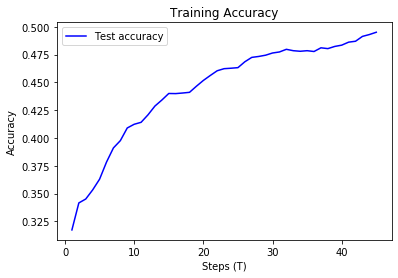

In [13]:
## your code here for evaluation of accuracy and plotting of results

evalutaion_scores=[]
for model in models_random:
     test_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,model)
     evalutaion_scores.append(test_accuracy)

iterations = range(1, len(evalutaion_scores) + 1)

plt.plot(iterations, evalutaion_scores, 'b', label='Test accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel("Steps (T)")
plt.ylabel("Accuracy")

plt.show()

# NOTE: Make Graphs and Check Evaluation Scores

## 3. Uncertainty sampling

In [14]:
def logistic_regression_entropy_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values.
    """
    # 
    prob = model.predict_proba(X)
    ent  = entropy(prob,axis=1)
    return ent

    

In [15]:
models_us = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_logistic_regression, 
                                 logistic_regression_entropy_select, 
                                 max_size, batch)

Training time: 0.7249767780303955s
[2.26142883 2.71952153 1.03284632 ... 1.50851878 2.02488799 2.6401271 ]
Accuracy after query 1: 0.3173
Training time: 0.673969030380249s
[2.26697429 2.66908128 1.33877953 ... 1.35989213 1.85927609 2.63685275]
Accuracy after query 2: 0.3340
Training time: 0.758969783782959s
[2.30725111 2.60088543 1.26482795 ... 1.40187088 1.79643963 2.66278569]
Accuracy after query 3: 0.3510
Training time: 0.7990012168884277s
[2.30580337 2.55533475 1.19189197 ... 1.15054771 1.64812137 2.55104387]
Accuracy after query 4: 0.3524
Training time: 0.8580029010772705s
[2.12791123 2.62852983 1.18575842 ... 0.93507785 1.79081109 2.56794031]
Accuracy after query 5: 0.3628
Training time: 0.9756665229797363s
[1.93220525 2.60607432 1.13719758 ... 1.00750913 1.85469752 2.53673153]
Accuracy after query 6: 0.3702
Training time: 0.8420016765594482s
[1.90089376 2.49051054 1.07880296 ... 1.12509544 1.81987549 2.43043431]
Accuracy after query 7: 0.3761
Training time: 1.062002182006836s
[1

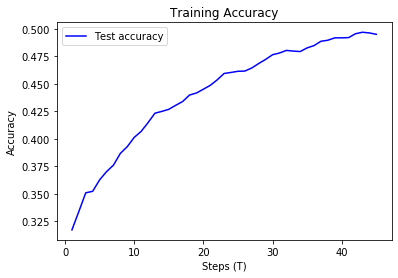

In [16]:
## your code here for evaluation of accuracy and plotting of results

evalutaion_scores=[]
for model in models_us:
     test_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,model)
     evalutaion_scores.append(test_accuracy)

iterations = range(1, len(evalutaion_scores) + 1)

plt.plot(iterations, evalutaion_scores, 'b', label='Test accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.xlabel("Steps (T)")
plt.ylabel("Accuracy")

plt.show()


## 4. Query by committee

In [17]:
# don't forget to provide function descriptive comments, like those provided in templates above

def query_by_committee_vote_entropy(X, model, **args):
    # This model is a tuple
    # enseble model use this to assign rank to each data point using bagging
    pass

def query_by_committee_soft_vote_entropy(X, model, **args):
    pass

def query_by_committee_KL(X, model, **args):
    pass

In [22]:
def train_committee(X, y, **args):

#  n_learner = 2
#  learner_list = list()
#  log_reg_1 = LogisticRegression(multi_class='multinomial',C=0.01,penalty='l2',solver='lbfgs')
#  log_reg_2 = LogisticRegression(multi_class='multinomial',C=0.1,penalty='l2',solver='lbfgs')
 
#  model_1 = log_reg_1.fit(X, y)
#  model_2 = log_reg_2.fit(X, y)

#  learner_list = [model_1,model_2]
    
#  return learner_list

 # 300 set
 # QBC
 # Ensemble  (Bagging)
 # Results
 # Regular Logistics Regression  

    

In [19]:
## your code here for training, evaluation, and plotting code


models_qbc_ve = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_committee, query_by_committee_vote_entropy, 
                                    max_size, batch)
models_qbc_ve_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model[2])


models_qbc_vse = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_committee, query_by_committee_soft_vote_entropy, 
                                    max_size, batch)
models_qbc_vse_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model[2])


models_qbc_kl = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_committee, query_by_committee_KL, 
                                    max_size, batch)
models_qbc_kl_accuracy = evaluate_logistic_regression_accuracy(X_test,y_test,Theta_model[2])





## 5. Hierarchical sampling

In [20]:
## your code